## Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

## Data Import

In [8]:
data_fMRI = pd.read_csv("./data_for_analysis/tsnr_voxel_data.csv")
data_fMRI.head(5)

,Voxel Value,X,Y,Z,Task,Subject
0,NaN,0,0,0,LanguageControl,sub-001
1,NaN,0,0,1,LanguageControl,sub-001
2,NaN,0,0,2,LanguageControl,sub-001
3,NaN,0,0,3,LanguageControl,sub-001
4,NaN,0,0,4,LanguageControl,sub-001


In [29]:
data_participants = pd.read_csv("./data_for_analysis/participants.tsv" , sep='\t')
data_participants = pd.DataFrame(data_participants)
data_participants = data_participants.rename(columns={'Chinese_writing': "C_wr", "Chinese_listening":"C_li","Chinese_speaking":"C_sp","Chinese_reading":"C_re",
                                                      "English_writing":"E_wr", "English_listening":"E_li", "English_speaking":"E_sp", "English_reading":"E_re"})
data_participants.head(5)

,participant_id,age,sex,task_order,task_rule,raven_score,AoA,CET_4_score,RT_L1S,RT_L1NS,...,ER_L2S,ER_L2NS,C_re,C_wr,C_sp,C_li,E_re,E_wr,E_sp,E_li
0,sub-001,20,F,Lan,Red,56,12,455,1068,948,...,0.050,0.050,8,7,6,6,4,4,4,4
1,sub-002,24,F,Lan,Red,55,13,576,918,832,...,0.025,0.025,8,7,8,8,5,6,4,4
2,sub-003,24,M,Lan,Red,60,7,543,951,859,...,0.000,0.000,9,7,8,8,9,6,6,7
3,sub-004,21,F,Lan,Red,47,8,564,1101,1023,...,0.050,0.025,7,6,8,7,5,5,4,3
4,sub-005,24,M,Lan,Blue,59,13,539,891,766,...,0.025,0.000,8,8,9,8,5,5,6,5


In [30]:
Language_RT = ["RT_L1S","RT_L1NS","RT_L2S","RT_L2NS"]
Language_ER = ["ER_L1S","ER_L1NS","ER_L2S","ER_L2NS"]

chinese_skills = ["C_wr", "C_li", "C_sp", "C_re"]
english_skills = ["E_wr", "E_li", "E_sp", "E_re"]

participants_pool = data_participants['participant_id'].unique().tolist()

participants_lang = data_participants[ ['participant_id', 'age', 'AoA',"CET_4_score"]+chinese_skills+english_skills+Language_RT+Language_ER]
participants_cog = data_participants[ ['participant_id', 'age', "raven_score"]+Language_RT+Language_ER]

In [31]:
participants_lang.head()

,participant_id,age,AoA,CET_4_score,C_wr,C_li,C_sp,C_re,E_wr,E_li,E_sp,E_re,RT_L1S,RT_L1NS,RT_L2S,RT_L2NS,ER_L1S,ER_L1NS,ER_L2S,ER_L2NS
0,sub-001,20,12,455,7,6,6,8,4,4,4,4,1068,948,1059,1027,0.000,0.000,0.050,0.050
1,sub-002,24,13,576,7,8,8,8,6,4,4,5,918,832,897,823,0.025,0.000,0.025,0.025
2,sub-003,24,7,543,7,8,8,9,6,7,6,9,951,859,883,841,0.000,0.000,0.000,0.000
3,sub-004,21,8,564,6,7,8,7,5,3,4,5,1101,1023,1000,935,0.050,0.075,0.050,0.025
4,sub-005,24,13,539,8,8,9,8,5,5,6,5,891,766,760,784,0.025,0.025,0.025,0.000


In [32]:
participants_cog.head()

,participant_id,age,raven_score,RT_L1S,RT_L1NS,RT_L2S,RT_L2NS,ER_L1S,ER_L1NS,ER_L2S,ER_L2NS
0,sub-001,20,56,1068,948,1059,1027,0.000,0.000,0.050,0.050
1,sub-002,24,55,918,832,897,823,0.025,0.000,0.025,0.025
2,sub-003,24,60,951,859,883,841,0.000,0.000,0.000,0.000
3,sub-004,21,47,1101,1023,1000,935,0.050,0.075,0.050,0.025
4,sub-005,24,59,891,766,760,784,0.025,0.025,0.025,0.000


In [11]:
lang_data = data_fMRI[data_fMRI['Task'] == ("LanguageControl")]
cog_data = data_fMRI[data_fMRI['Task'] == ("CognitiveControl")]

### Voxel Average

In [ ]:
voxel_avg_lang = (
    lang_data.groupby(['X', 'Y', 'Z'])['Voxel Value']
    .mean()
    .reset_index()
    .rename(columns={'Voxel Value': 'voxel_avg'})
)

voxel_avg_cog = (
    cog_data.groupby(['X', 'Y', 'Z'])['Voxel Value']
    .mean()
    .reset_index()
    .rename(columns={'Voxel Value': 'voxel_avg'})
)



In [47]:
voxel_avgs = pd.merge(
    voxel_avg_lang,
    voxel_avg_cog,
    on=['X', 'Y', 'Z'],
    suffixes=('_lang', '_cog')
)
voxel_avgs["voxel_diff"] = voxel_avgs["voxel_avg_cog"] - voxel_avgs["voxel_avg_lang"]
lang_voxel = voxel_avgs[voxel_avgs["voxel_avg_lang"] > voxel_avgs["voxel_avg_cog"]]
cog_voxel = voxel_avgs[voxel_avgs["voxel_avg_lang"] < voxel_avgs["voxel_avg_cog"]]
voxel_avgs.head()

,X,Y,Z,voxel_avg_lang,voxel_avg_cog,voxel_diff
0,2,22,16,9.727637,16.693541,6.965904
1,2,22,17,17.039139,14.699125,-2.340015
2,2,22,18,12.713935,21.485306,8.771371
3,2,22,19,24.440159,12.852101,-11.588058
4,2,23,16,24.714548,24.915525,0.200977


In [13]:
fig = px.scatter_3d(
    voxel_avg_lang,
    x='X', y='Y', z='Z',
    color='voxel_avg',
    color_continuous_scale='Viridis',
    opacity=0.6,
    title='3D Voxel Average Intensity'
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    coloraxis_colorbar=dict(title='Voxel Avg')
)

fig.show()
fig.write_html("lang_voxel_3d_plot.html")

In [14]:
fig = px.scatter_3d(
    voxel_avg_cog,
    x='X', y='Y', z='Z',
    color='voxel_avg',
    color_continuous_scale='Viridis',
    opacity=0.6,
    title='3D Voxel Average Intensity'
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    coloraxis_colorbar=dict(title='Voxel Avg')
)

fig.show()
fig.write_html("cog_voxel_3d_plot.html")

## Linear Regression

In [ ]:
train_participants, test_participants = train_test_split(
    participants_pool, test_size=0.2, random_state=42
)

In [48]:
lang_voxel.head()

,X,Y,Z,voxel_avg_lang,voxel_avg_cog,voxel_diff
1,2,22,17,17.039139,14.699125,-2.340015
3,2,22,19,24.440159,12.852101,-11.588058
20,2,25,19,19.238075,17.697211,-1.540864
27,2,26,17,23.699517,22.849283,-0.850234
33,2,26,23,17.401271,16.970501,-0.430771


In [ ]:
data_sub = data_fMRI.groupby(['Subject', 'Task','X','Y','Z'])['voxel_avg_lang'].mean().reset_index()
data_sub = data_sub.rename(columns={'Subject':"participant_id"})




In [43]:
lang = pd.merge(
    participants_lang,
    data_sub,
    on=["participant_id"],
)
lang = lang[lang['Task'] == 'LanguageControl'].drop(columns=['Task'])

lang.head()

,participant_id,age,AoA,CET_4_score,C_wr,C_li,C_sp,C_re,E_wr,E_li,...,E_re,RT_L1S,RT_L1NS,RT_L2S,RT_L2NS,ER_L1S,ER_L1NS,ER_L2S,ER_L2NS,vox_val
1,sub-001,20,12,455,7,6,6,8,4,4,...,4,1068,948,1059,1027,0.000,0.000,0.050,0.050,78.101625
3,sub-002,24,13,576,7,8,8,8,6,4,...,5,918,832,897,823,0.025,0.000,0.025,0.025,75.208151
5,sub-003,24,7,543,7,8,8,9,6,7,...,9,951,859,883,841,0.000,0.000,0.000,0.000,74.746632
7,sub-004,21,8,564,6,7,8,7,5,3,...,5,1101,1023,1000,935,0.050,0.075,0.050,0.025,86.154365
9,sub-005,24,13,539,8,8,9,8,5,5,...,5,891,766,760,784,0.025,0.025,0.025,0.000,71.250530


In [44]:
cog = pd.merge(
    participants_cog,
    data_sub,
    on=["participant_id"],
)
cog = cog[cog['Task'] == 'CognitiveControl'].drop(columns=['Task'])

cog.head()

,participant_id,age,raven_score,RT_L1S,RT_L1NS,RT_L2S,RT_L2NS,ER_L1S,ER_L1NS,ER_L2S,ER_L2NS,vox_val
0,sub-001,20,56,1068,948,1059,1027,0.000,0.000,0.050,0.050,93.624113
2,sub-002,24,55,918,832,897,823,0.025,0.000,0.025,0.025,88.034885
4,sub-003,24,60,951,859,883,841,0.000,0.000,0.000,0.000,80.768441
6,sub-004,21,47,1101,1023,1000,935,0.050,0.075,0.050,0.025,92.985642
8,sub-005,24,59,891,766,760,784,0.025,0.025,0.025,0.000,86.070275


### Language Control

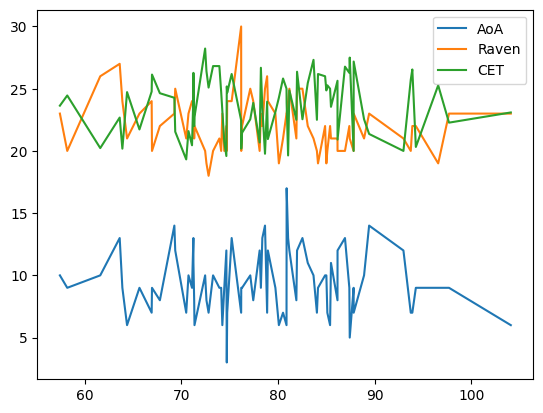

In [46]:
lang_graph = lang.sort_values(by='vox_val')

vox_val = lang_graph['vox_val'].to_list()
y_AoA = lang_graph['AoA'].to_list()
y_CET = lang_graph['CET_4_score'].to_list()
y_age = lang_graph['age'].to_list()
y_CET = [float(i)/22 for i in y_CET]

plt.plot(vox_val, y_AoA , label='AoA')
plt.plot(vox_val, y_age, label='Raven')
plt.plot(vox_val, y_CET, label='CET')

plt.legend()
plt.show()

### Cognitive Control